# US Road Accidents Severity Prediction 

In [1]:
import pandas as pd
import numpy as np
import json
import os

## 1.0 Creating DB and tables and inserting data in the DB

In [2]:
### Importing the complete dataset as a list to insert into the DB

filename = "US_Accidents_Dec20_updated.csv"

# df_test = pd.read_csv(filename)
# df_test

raw_data = []

with open(filename, 'r') as file:
    for line in file:
        if not line.strip():
            continue
            
        raw_data.append(line.strip().split(','))

In [3]:
print(raw_data[:2])
print(len(raw_data[0]))
#Amenity, Bump, Crossing, Give_Way, Junction, No_Exit, Railway, Roundabout, Station, Stop,Traffic_Calming, Traffic_Signal, Turning_Loop


# I'm removing Start_Time, End_Time, Number, Distance(mi), Description, Country, Timezone, Airport_Code

[['ID', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng', 'Distance(mi)', 'Description', 'Number', 'Street', 'Side', 'City', 'County', 'State', 'Zipcode', 'Country', 'Timezone', 'Airport_Code', 'Weather_Timestamp', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight'], ['A-2716600', '3', '2016-02-08 00:37:08', '2016-02-08 06:37:08', '40.10891', '-83.09286', '40.11206', '-83.03187', '3.23', 'Between Sawmill Rd/Exit 20 and OH-315/Olentangy Riv Rd/Exit 22 - Accident.', '', 'Outerbelt E', 'R', 'Dublin', 'Franklin', 'OH', '43017', 'US', 'US/Eastern', 'KOSU', '2016-02-08 00:53:00', '42.1', '36.1', '58.0', '29

In [4]:
### Utility Functions - For creating and quering the db

from IPython.display import display, HTML
import pandas as pd
import sqlite3
from sqlite3 import Error

def create_connection(db_file, delete_db=False):
    import os
    if delete_db and os.path.exists(db_file):
        os.remove(db_file)

    conn = None
    try:
        conn = sqlite3.connect(db_file)
        conn.execute("PRAGMA foreign_keys = 1")
    except Error as e:
        print(e)

    return conn


def create_table(conn, create_table_sql, drop_table_name=None):
    
    if drop_table_name: # You can optionally pass drop_table_name to drop the table. 
        try:
            c = conn.cursor()
            c.execute("""DROP TABLE IF EXISTS %s""" % (drop_table_name))
        except Error as e:
            print(e)
    
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)

        
def execute_sql_statement(sql_statement, conn):
    cur = conn.cursor()
    cur.execute(sql_statement)

    rows = cur.fetchall()

    return rows

In [5]:
### Creating DB and connection

db_filename = 'my_database.db'
conn = create_connection(db_filename, delete_db=True)

In [6]:
!ls

Accidents.html
LightGBM
Python_Project-2.ipynb
Python_Project-3.ipynb
Python_Project_(updated by Abhishek).ipynb
Python_Project_Swayanok.ipynb
Python_Project_final_v2.ipynb
US_Accidents_Dec20_updated.csv
build
my_database.db


In [7]:
### Creating tables

# 1. Severity
create_table_Severity = """CREATE TABLE [Severity] (
                            [Id] TEXT PRIMARY KEY NOT NULL,
                            [Severity] INTEGER NOT NULL
                            );"""

# 2. GeoDetails
create_table_GeoDetails = """CREATE TABLE [GeoDetails] (
                            [Id] TEXT PRIMARY KEY NOT NULL,
                            [Start_Lat] FLOAT, 
                            [Start_Lng] FLOAT, 
                            [End_Lat] FLOAT, 
                            [End_Lng] FLOAT,    
                            [Street] TEXT, 
                            [Side] TEXT, 
                            [City] TEXT, 
                            [County] TEXT, 
                            [State] TEXT, 
                            [Zipcode] TEXT,
                            FOREIGN KEY (Id) REFERENCES Severity (Id)
                            );"""
# 3. Weather
create_table_Weather = """CREATE TABLE [Weather] (
                        [Id] TEXT PRIMARY KEY NOT NULL,
                        [Timestamp] DATE, 
                        [Temperature] FLOAT, 
                        [Wind_Chill] FLOAT, 
                        [Humidity] FLOAT, 
                        [Pressure] FLOAT, 
                        [Visibility] FLOAT, 
                        [Wind_Direction] TEXT, 
                        [Wind_Speed] FLOAT, 
                        [Precipitation] FLOAT, 
                        [Condition] TEXT,
                        FOREIGN KEY (Id) REFERENCES Severity (Id)
                        );"""

# 4. LocDet
create_table_LocDet = """CREATE TABLE [LocDet] (
                        [Id] TEXT PRIMARY KEY NOT NULL,
                        [Amenity] BOOLEAN, 
                        [Bump] BOOLEAN, 
                        [Crossing] BOOLEAN, 
                        [Give_Way] BOOLEAN, 
                        [Junction] BOOLEAN, 
                        [No_Exit] BOOLEAN, 
                        [Railway] BOOLEAN, 
                        [Roundabout] BOOLEAN, 
                        [Station] BOOLEAN, 
                        [Stop] BOOLEAN, 
                        [Traffic_Calming] BOOLEAN, 
                        [Traffic_Signal] BOOLEAN, 
                        [Turning_Loop] BOOLEAN,
                        FOREIGN KEY (Id) REFERENCES Severity (Id)
                        );"""

# 5. Twilight
create_table_Twilight = """CREATE TABLE [Twilight] (
                        [Id] TEXT PRIMARY KEY NOT NULL,
                        [Sunrise_Sunset] TEXT, 
                        [Civil_Twilight] TEXT, 
                        [Nautical_Twilight] TEXT, 
                        [Astronomical_Twilight] TEXT,
                        FOREIGN KEY (Id) REFERENCES Severity (Id)
                        );"""



# Actually creating the table
with conn:
    create_table(conn, create_table_Severity)
    create_table(conn, create_table_GeoDetails)
    create_table(conn, create_table_Weather)
    create_table(conn, create_table_LocDet)
    create_table(conn, create_table_Twilight)

In [8]:
### Inserting data into Severity table

# Get the values
severity_values = []

for elem in raw_data[1:]:
    ele_id, ele_sev = elem[0:2]
    severity_values.append((ele_id, ele_sev))

# Insert function
def insert_into_Severity(conn, values):
    sql = """INSERT INTO Severity(Id, Severity)
           Values(?, ?);"""
    cur = conn.cursor()
    cur.executemany(sql, values)
    return cur.lastrowid

# Insert the values in table
with conn:
    insert_into_Severity(conn, severity_values)

In [9]:
### Inserting data into LocDet table

# Get the values
locdet_values = []

for elem in raw_data[1:]:
    ele_id = elem[0]
    Amenity, Bump, Crossing, Give_Way, Junction, No_Exit, Railway, Roundabout, Station, Stop,Traffic_Calming, Traffic_Signal, Turning_Loop = elem[30:43]
    locdet_values.append((ele_id, Amenity, Bump, Crossing, Give_Way, Junction, No_Exit, Railway, Roundabout, Station, Stop,Traffic_Calming, Traffic_Signal, Turning_Loop))

# print(locdet_values[:10])    

# Insert function
def insert_into_LocDet(conn, values):
    sql = """INSERT INTO LocDet(Id, Amenity, Bump, Crossing, Give_Way, Junction, No_Exit, Railway, Roundabout, Station, Stop,Traffic_Calming, Traffic_Signal, Turning_Loop)
           Values(?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ? , ?);"""
    cur = conn.cursor()
    cur.executemany(sql, values)
    return cur.lastrowid

# Insert the values in table
with conn:
    insert_into_LocDet(conn, locdet_values)

In [10]:
### Inserting data into Weather table

# Get the values
weather_values = []

for elem in raw_data[1:]:
    ele_id = elem[0]
    Timestamp, Temperature, Wind_Chill,Humidity,Pressure,Visibility,Wind_Direction,Wind_Speed,Precipitation,Condition = elem[20:30]
    weather_values.append((ele_id, Timestamp, Temperature, Wind_Chill,Humidity,Pressure,Visibility,Wind_Direction,Wind_Speed,Precipitation,Condition))

# print(weather_values[:10])
    
### Insert function
def insert_into_Geo(conn, values):
    sql = """INSERT INTO Weather(Id, Timestamp, Temperature, Wind_Chill,Humidity,Pressure,Visibility,Wind_Direction,Wind_Speed,Precipitation,Condition)
           Values(?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?);"""
    cur = conn.cursor()
    cur.executemany(sql, values)
    return cur.lastrowid

# Insert the values in table
with conn:
    insert_into_Geo(conn, weather_values)

In [11]:
### Inserting data into GeoDetails table

# Get the values
geo_values = []

for elem in raw_data[1:]:
    ele_id = elem[0]
    start_lat, start_lon, end_lat, end_lon = elem[4:8]
    street, side, city, county, state, zipcode = elem[11:17]
    geo_values.append((ele_id, start_lat, start_lon, end_lat, end_lon, street, side, city, county, state, zipcode))

# Insert function
def insert_into_Geo(conn, values):
    sql = """INSERT INTO GeoDetails(Id, Start_Lat, Start_Lng, End_Lat, End_Lng, Street, Side, City, County, State, Zipcode)
           Values(?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?);"""
    cur = conn.cursor()
    cur.executemany(sql, values)
    return cur.lastrowid

# Insert the values in table
with conn:
    insert_into_Geo(conn, geo_values)

In [12]:
### Inserting data into Twilight table

# Get the values
twilight_values = []

for elem in raw_data[1:]:
    ele_id = elem[0]
    Sunrise_Sunset, Civil_Twilight, Nautical_Twilight, Astronomical_Twilight = elem[43:]
    twilight_values.append((ele_id, Sunrise_Sunset, Civil_Twilight, Nautical_Twilight, Astronomical_Twilight))

# Insert function
def insert_into_twilight(conn, values):
    sql = """INSERT INTO Twilight(Id,Sunrise_Sunset, Civil_Twilight, Nautical_Twilight, Astronomical_Twilight)
           Values(?, ?, ?, ?, ? );"""
    cur = conn.cursor()
    cur.executemany(sql, values)
    return cur.lastrowid

# Insert the values in table
with conn:
    insert_into_twilight(conn, twilight_values)

In [13]:
### Creating dataframes from db tables

df_severity = pd.read_sql_query("""SELECT * FROM Severity""", conn)
# display(df_severity)

df_geodetails = pd.read_sql_query("""SELECT * FROM GeoDetails""", conn)
# print(df_geodetails)

df_weather = pd.read_sql_query("""SELECT * FROM Weather""", conn)
# display(df_weather)

df_locdet = pd.read_sql_query("""SELECT * FROM LocDet""", conn)
# df_locdet.describe()

df_twilight = pd.read_sql_query("""SELECT * FROM Twilight""", conn)
# display(df_twilight)

In [14]:
### Merging dfs to create final df for analysis

df = df_severity.merge(df_geodetails, on = 'Id')

df = df.merge(df_locdet, on = 'Id')
# print(df)
df = df.merge(df_twilight, on = 'Id')
data = df.merge(df_weather, on = 'Id')

# print(data.info())
data = data.replace('', np.NaN)
data = data.replace('False', bool(False))
data = data.replace('True', bool(True))
# data.describe()

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1516064 entries, 0 to 1516063
Data columns (total 39 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Id                     1516064 non-null  object 
 1   Severity               1516064 non-null  int64  
 2   Start_Lat              1516064 non-null  float64
 3   Start_Lng              1516064 non-null  float64
 4   End_Lat                1516064 non-null  float64
 5   End_Lng                1516064 non-null  float64
 6   Street                 1516064 non-null  object 
 7   Side                   1516064 non-null  object 
 8   City                   1515981 non-null  object 
 9   County                 1516064 non-null  object 
 10  State                  1516064 non-null  object 
 11  Zipcode                1515129 non-null  object 
 12  Amenity                1516064 non-null  bool   
 13  Bump                   1516064 non-null  bool   
 14  Crossing          

## 2.0 Exploratory Data Analysis and model Data Preprocessing

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import datetime 
import calendar
import seaborn as sns
from sklearn import metrics
from sklearn import tree
from sklearn.metrics import r2_score
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
%matplotlib inline

In [17]:
pd.set_option("max_columns",None)

In [19]:
missing= data.isna().sum().sort_values(ascending = False)/len(data) * 100
missing
#sort out the ones with zeroes
missing[missing != 0]

Precipitation            33.675953
Wind_Chill               29.637007
Wind_Speed                8.499773
Humidity                  3.001786
Visibility                2.916170
Condition                 2.902714
Temperature               2.838469
Wind_Direction            2.760965
Pressure                  2.392643
Timestamp                 1.996222
Zipcode                   0.061673
Nautical_Twilight         0.005475
Civil_Twilight            0.005475
Astronomical_Twilight     0.005475
City                      0.005475
Sunrise_Sunset            0.005475
dtype: float64

<AxesSubplot:>

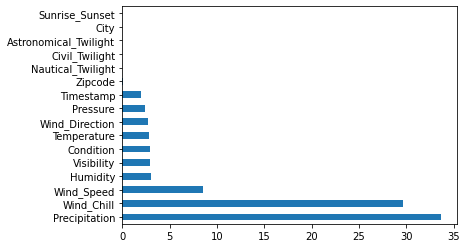

In [20]:
missing[missing != 0].plot(kind = 'barh')

In [21]:
data.head()

Id  Severity  Start_Lat  Start_Lng   End_Lat   End_Lng       Street  \
0  A-2716600         3   40.10891  -83.09286  40.11206 -83.03187  Outerbelt E   
1  A-2716601         2   39.86542  -84.06280  39.86501 -84.04873       I-70 E   
2  A-2716602         2   39.10266  -84.52468  39.10209 -84.52396       I-75 S   
3  A-2716603         2   39.10148  -84.52341  39.09841 -84.52241      US-50 E   
4  A-2716604         2   41.06213  -81.53784  41.06217 -81.53547       I-77 N   

  Side        City      County State Zipcode  Amenity   Bump  Crossing  \
0    R      Dublin    Franklin    OH   43017    False  False     False   
1    R      Dayton  Montgomery    OH   45424    False  False     False   
2    R  Cincinnati    Hamilton    OH   45203    False  False     False   
3    R  Cincinnati    Hamilton    OH   45202    False  False     False   
4    R       Akron      Summit    OH   44311    False  False     False   

   Give_Way  Junction  No_Exit  Railway  Roundabout  Station   Stop  \
0     False     False    False    False       False    False  False   
1     False     False    False    False       False    False  False   
2     False      True    False    False       False    False  False   
3     False      True    False    False       False    False  False   
4     False     False    False    False       False    False  False   

   Traffic_Calming  Traffic_Signal  Turning_Loop Sunrise_Sunset  \
0            False           False         False          Night   
1            False           False         False          Night   
2            False           False         False          Night   
3            False           False         False          Night   
4            False           False         False          Night   

  Civil_Twilight Nautical_Twilight Astronomical_Twilight            Timestamp  \
0          Night             Night                 Night  2016-02-08 00:53:00   
1          Night             Night                 Night  2016-02-08 05:58:00   
2          Night             Night                   Day  2016-02-08 05:53:00   
3          Night             Night                   Day  2016-02-08 05:53:00   
4          Night               Day                   Day  2016-02-08 06:54:00   

   Temperature  Wind_Chill  Humidity  Pressure  Visibility Wind_Direction  \
0         42.1        36.1      58.0     29.76        10.0             SW   
1         36.9         NaN      91.0     29.68        10.0           Calm   
2         36.0         NaN      97.0     29.70        10.0           Calm   
3         36.0         NaN      97.0     29.70        10.0           Calm   
4         39.0         NaN      55.0     29.65        10.0           Calm   

   Wind_Speed  Precipitation   Condition  
0        10.4           0.00  Light Rain  
1         NaN           0.02  Light Rain  
2         NaN           0.02    Overcast  
3         NaN           0.02    Overcast  
4         NaN            NaN    Overcast

In [22]:
# !pip install sweetviz
# !pip install ipywidgets
# !pip install -U jupyter

# import sweetviz as sv
# advert_report = sv.analyze(data)

# #display the report
# advert_report.show_html('Accidents.html')

In [23]:
# import os
# os.getcwd()

In [24]:
# check the no. of columns & rows
print('The Dataset Contains, Rows: {:,d} & Columns: {}'.format(data.shape[0], data.shape[1]))

The Dataset Contains, Rows: 1,516,064 & Columns: 39


In [25]:
city_data = pd.DataFrame(data['City'].value_counts()).reset_index().rename(columns={'index':'City', 'City':'Cases'})

In [26]:
# !pip install plotly.express
# import pandas as pd
import plotly.express as px

In [27]:
data.describe()

Severity     Start_Lat     Start_Lng       End_Lat       End_Lng  \
count  1.516064e+06  1.516064e+06  1.516064e+06  1.516064e+06  1.516064e+06   
mean   2.238630e+00  3.690056e+01 -9.859919e+01  3.690061e+01 -9.859901e+01   
std    6.081481e-01  5.165653e+00  1.849602e+01  5.165629e+00  1.849590e+01   
min    1.000000e+00  2.457022e+01 -1.244976e+02  2.457011e+01 -1.244978e+02   
25%    2.000000e+00  3.385422e+01 -1.182076e+02  3.385420e+01 -1.182077e+02   
50%    2.000000e+00  3.735113e+01 -9.438100e+01  3.735134e+01 -9.437987e+01   
75%    2.000000e+00  4.072593e+01 -8.087469e+01  4.072593e+01 -8.087449e+01   
max    4.000000e+00  4.900058e+01 -6.711317e+01  4.907500e+01 -6.710924e+01   

        Temperature    Wind_Chill      Humidity      Pressure    Visibility  \
count  1.473031e+06  1.066748e+06  1.470555e+06  1.479790e+06  1.471853e+06   
mean   5.958460e+01  5.510976e+01  6.465960e+01  2.955495e+01  9.131755e+00   
std    1.827316e+01  2.112735e+01  2.325986e+01  1.016756e+00  2.889112e+00   
min   -8.900000e+01 -8.900000e+01  1.000000e+00  0.000000e+00  0.000000e+00   
25%    4.700000e+01  4.080000e+01  4.800000e+01  2.944000e+01  1.000000e+01   
50%    6.100000e+01  5.700000e+01  6.800000e+01  2.988000e+01  1.000000e+01   
75%    7.300000e+01  7.100000e+01  8.400000e+01  3.004000e+01  1.000000e+01   
max    1.706000e+02  1.130000e+02  1.000000e+02  5.804000e+01  1.400000e+02   

         Wind_Speed  Precipitation  
count  1.387202e+06   1.005515e+06  
mean   7.630812e+00   8.477855e-03  
std    5.637364e+00   1.293168e-01  
min    0.000000e+00   0.000000e+00  
25%    4.600000e+00   0.000000e+00  
50%    7.000000e+00   0.000000e+00  
75%    1.040000e+01   0.000000e+00  
max    9.840000e+02   2.400000e+01

In [28]:
from textwrap import wrap

named_colorscales = px.colors.named_colorscales()
print("\n".join(wrap("".join('{:<12}'.format(c) for c in named_colorscales), 96)))

aggrnyl     agsunset    blackbody   bluered     blues       blugrn      bluyl       brwnyl
bugn        bupu        burg        burgyl      cividis     darkmint    electric    emrld
gnbu        greens      greys       hot         inferno     jet         magenta     magma
mint        orrd        oranges     oryel       peach       pinkyl      plasma      plotly3
pubu        pubugn      purd        purp        purples     purpor      rainbow     rdbu
rdpu        redor       reds        sunset      sunsetdark  teal        tealgrn     turbo
viridis     ylgn        ylgnbu      ylorbr      ylorrd      algae       amp         deep
dense       gray        haline      ice         matter      solar       speed       tempo
thermal     turbid      armyrose    brbg        earth       fall        geyser      prgn
piyg        picnic      portland    puor        rdgy        rdylbu      rdylgn      spectral
tealrose    temps       tropic      balance     curl        delta       oxy         edge
hsv     

In [29]:
data1 = data

In [30]:
#Top 15 cities by the number of accidents
cities = data1.City.value_counts()
cities[:15]

Los Angeles    39984
Miami          36233
Charlotte      22203
Houston        20843
Dallas         19497
Sacramento     18431
Orlando        16169
Portland       14805
San Diego      14090
Minneapolis    12653
Atlanta        11854
Chicago        11507
Saint Paul     10084
Phoenix         9934
Raleigh         9516
Name: City, dtype: int64

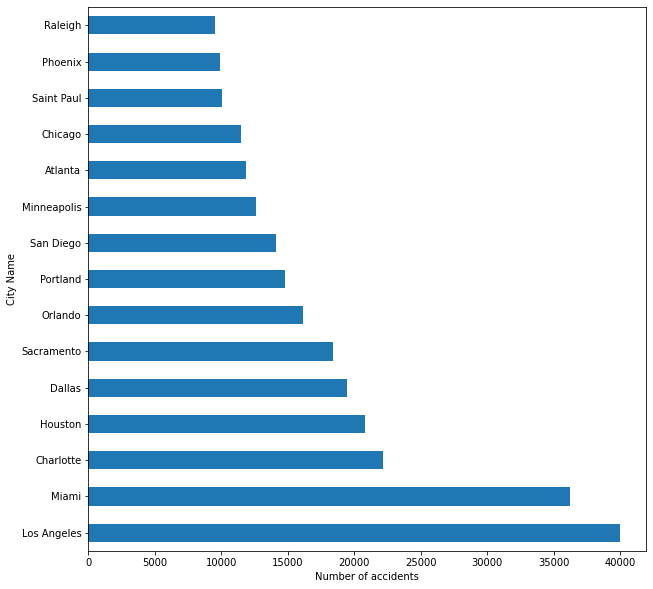

In [31]:
plt.figure(figsize=(10,10))
city = cities[:15].plot(kind='barh')
city.set(xlabel='Number of accidents', ylabel='City Name')
plt.show()

We can see that Los Angeles, Miami and Charlotte are top 3 cities having the highest number of accidents. 

States of top 50 cities by number of accidents

In [32]:
total = 0
for i in cities[:50]:
    total += i
print(total)
print(total/len(data1))

480964
0.3172451822614349


The total number of accidents from the top 50 cities by number of accidents is equal to 480964 which is almost 32% of the entire dataset.

In [33]:
cities_list = data1.City.value_counts().index.tolist()
states_dict = {}
for city in cities_list[:50]:
    state = data1[data1.City == city].iloc[0].State
    if state in states_dict.keys():
        states_dict[state] = states_dict[state] + 1
    else:
        states_dict[state] = 1

states_dict = {key: value for key, value in sorted(states_dict.items(), key=lambda item: item[1], reverse=True)}

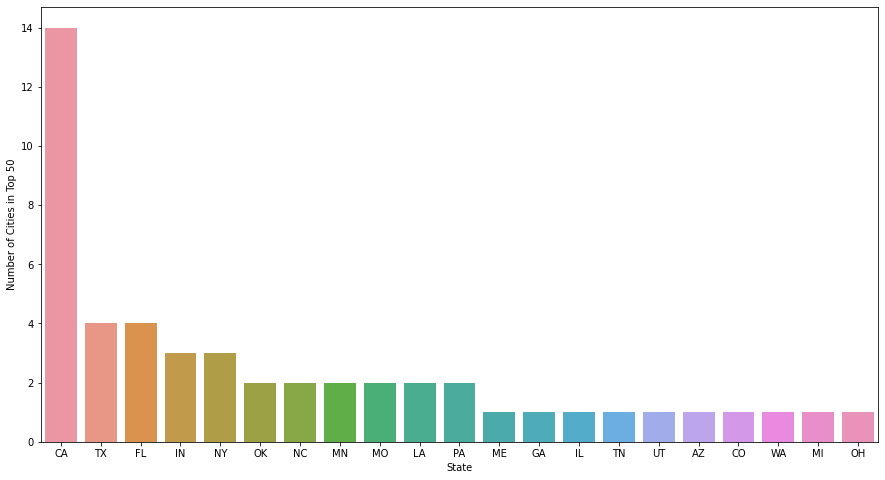

In [34]:
keys = list(states_dict.keys())
vals = [int(states_dict[k]) for k in keys]
plt.figure(figsize=(15,8))
ax = sns.barplot(x=keys, y=vals)
ax.set(xlabel='State', ylabel='Number of Cities in Top 50')
plt.show()

We can observe that 14 out of 50 cities that contribute the highest number of accidents belong to California. The other states in the top 5 are Texas, Florida, Indiana and New York.

In [35]:
data1['Timestamp'] = pd.to_datetime(data1['Timestamp'])

In [36]:
data2 = data1[['Timestamp']].copy()

In [37]:
data2 ['Day'] = data2 ['Timestamp'].dt.day
data2 ['Month'] = data2 ['Timestamp'].dt.month
data2 ['Year'] = data2 ['Timestamp'].dt.year
data2 ['Weekday'] = data2 ['Timestamp'].dt.weekday
data2 ['Hour'] = data2 ['Timestamp'].dt.hour

In [38]:
data2.head()

Timestamp  Day  Month    Year  Weekday  Hour
0 2016-02-08 00:53:00  8.0    2.0  2016.0      0.0   0.0
1 2016-02-08 05:58:00  8.0    2.0  2016.0      0.0   5.0
2 2016-02-08 05:53:00  8.0    2.0  2016.0      0.0   5.0
3 2016-02-08 05:53:00  8.0    2.0  2016.0      0.0   5.0
4 2016-02-08 06:54:00  8.0    2.0  2016.0      0.0   6.0

/usr/local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Number of Accidents per Month')

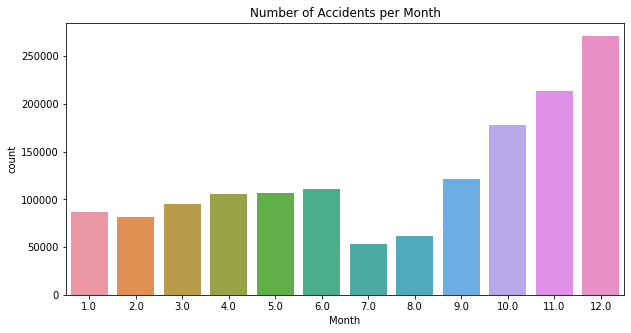

In [39]:
plt.figure(figsize = (10,5))
sns.countplot(data2.Month)
plt.title('Number of Accidents per Month')

In [40]:
data1['Temperature']

0          42.1
1          36.9
2          36.0
3          36.0
4          39.0
           ... 
1516059    86.0
1516060    70.0
1516061    73.0
1516062    71.0
1516063    79.0
Name: Temperature, Length: 1516064, dtype: float64

In [41]:
temp = pd.DataFrame(data1['Temperature'].value_counts(bins=np.arange(-20, 170, 5), sort=False).reset_index())

In [42]:
temp.columns = ['Temperature', 'No. of Accidents']
temp.head()

Temperature  No. of Accidents
0  (-20.001, -15.0]               103
1    (-15.0, -10.0]               192
2     (-10.0, -5.0]               809
3       (-5.0, 0.0]              1940
4        (0.0, 5.0]              3412

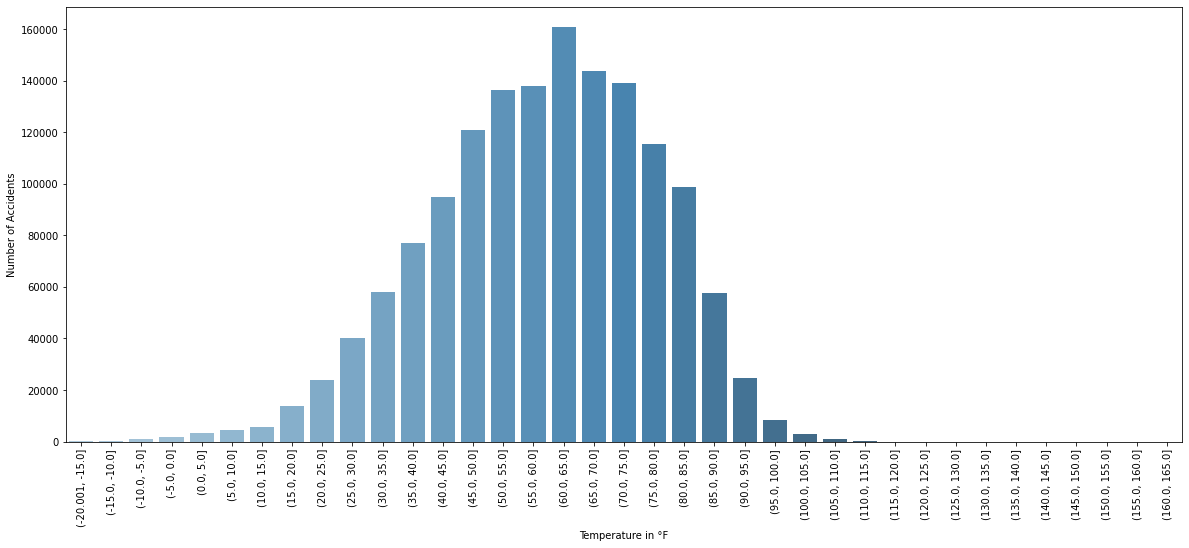

In [43]:
plt.figure(figsize=(20, 8))
x = sns.barplot(data=temp, x='Temperature', y='No. of Accidents', palette="Blues_d")
x.set(xlabel='Temperature in °F', ylabel='Number of Accidents')
plt.xticks(rotation = 90)
plt.show()

Here we can observe that the number of accidents is not high in warmer or colder areas. In fact, the number of accidents is lower in these areas, because of lower population in these areas as most people might not live in extreme conditions.

In [44]:
schoropleth=px.choropleth(data_frame=data,locations=data.State.value_counts().index,locationmode='USA-states',color=data.State.value_counts().array,color_continuous_scale='purples',scope='usa',title='USA')
schoropleth.update_layout(paper_bgcolor='#ffffff',showlegend=True, title_x=1)
schoropleth.show()

In [45]:
data.columns

Index(['Id', 'Severity', 'Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng',
       'Street', 'Side', 'City', 'County', 'State', 'Zipcode', 'Amenity',
       'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway',
       'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal',
       'Turning_Loop', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight', 'Timestamp', 'Temperature', 'Wind_Chill',
       'Humidity', 'Pressure', 'Visibility', 'Wind_Direction', 'Wind_Speed',
       'Precipitation', 'Condition'],
      dtype='object')

In [46]:
data_frame=data.City.value_counts()[:15]

In [47]:
data.City.value_counts()

Los Angeles    39984
Miami          36233
Charlotte      22203
Houston        20843
Dallas         19497
               ...  
Pray               1
Crooksville        1
Placida            1
Red Bay            1
Merigold           1
Name: City, Length: 10657, dtype: int64

<AxesSubplot:xlabel='Severity', ylabel='Count'>

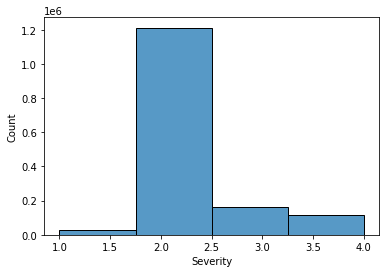

In [48]:
# !pip install -U seaborn
sns.histplot(data.Severity,bins=4)

Text(0.5, 1.0, 'Accidents Severity heatmap in US ')

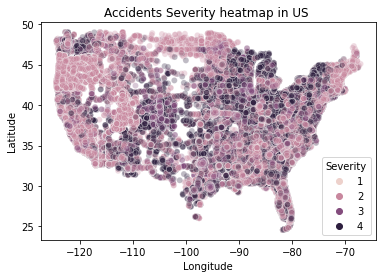

In [49]:
# Lets see if we can get any insights form the scatter plot of latitude and longitude
sns.scatterplot(y=data.Start_Lat,x=data.Start_Lng,hue=data.Severity,alpha=0.3)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Accidents Severity heatmap in US ")

In [50]:
data.Timestamp=pd.to_datetime(data.Timestamp)

<Figure size 864x504 with 0 Axes>

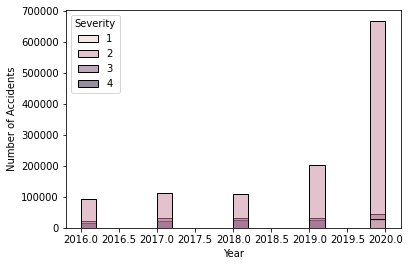

<Figure size 864x504 with 0 Axes>

In [51]:
sns.histplot(x=data.Timestamp.dt.year,bins=20,hue=data.Severity)
plt.xlabel("Year")
plt.ylabel("Number of Accidents")
plt.figure(figsize=(12,7))

<AxesSubplot:xlabel='Timestamp', ylabel='Count'>

/usr/local/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



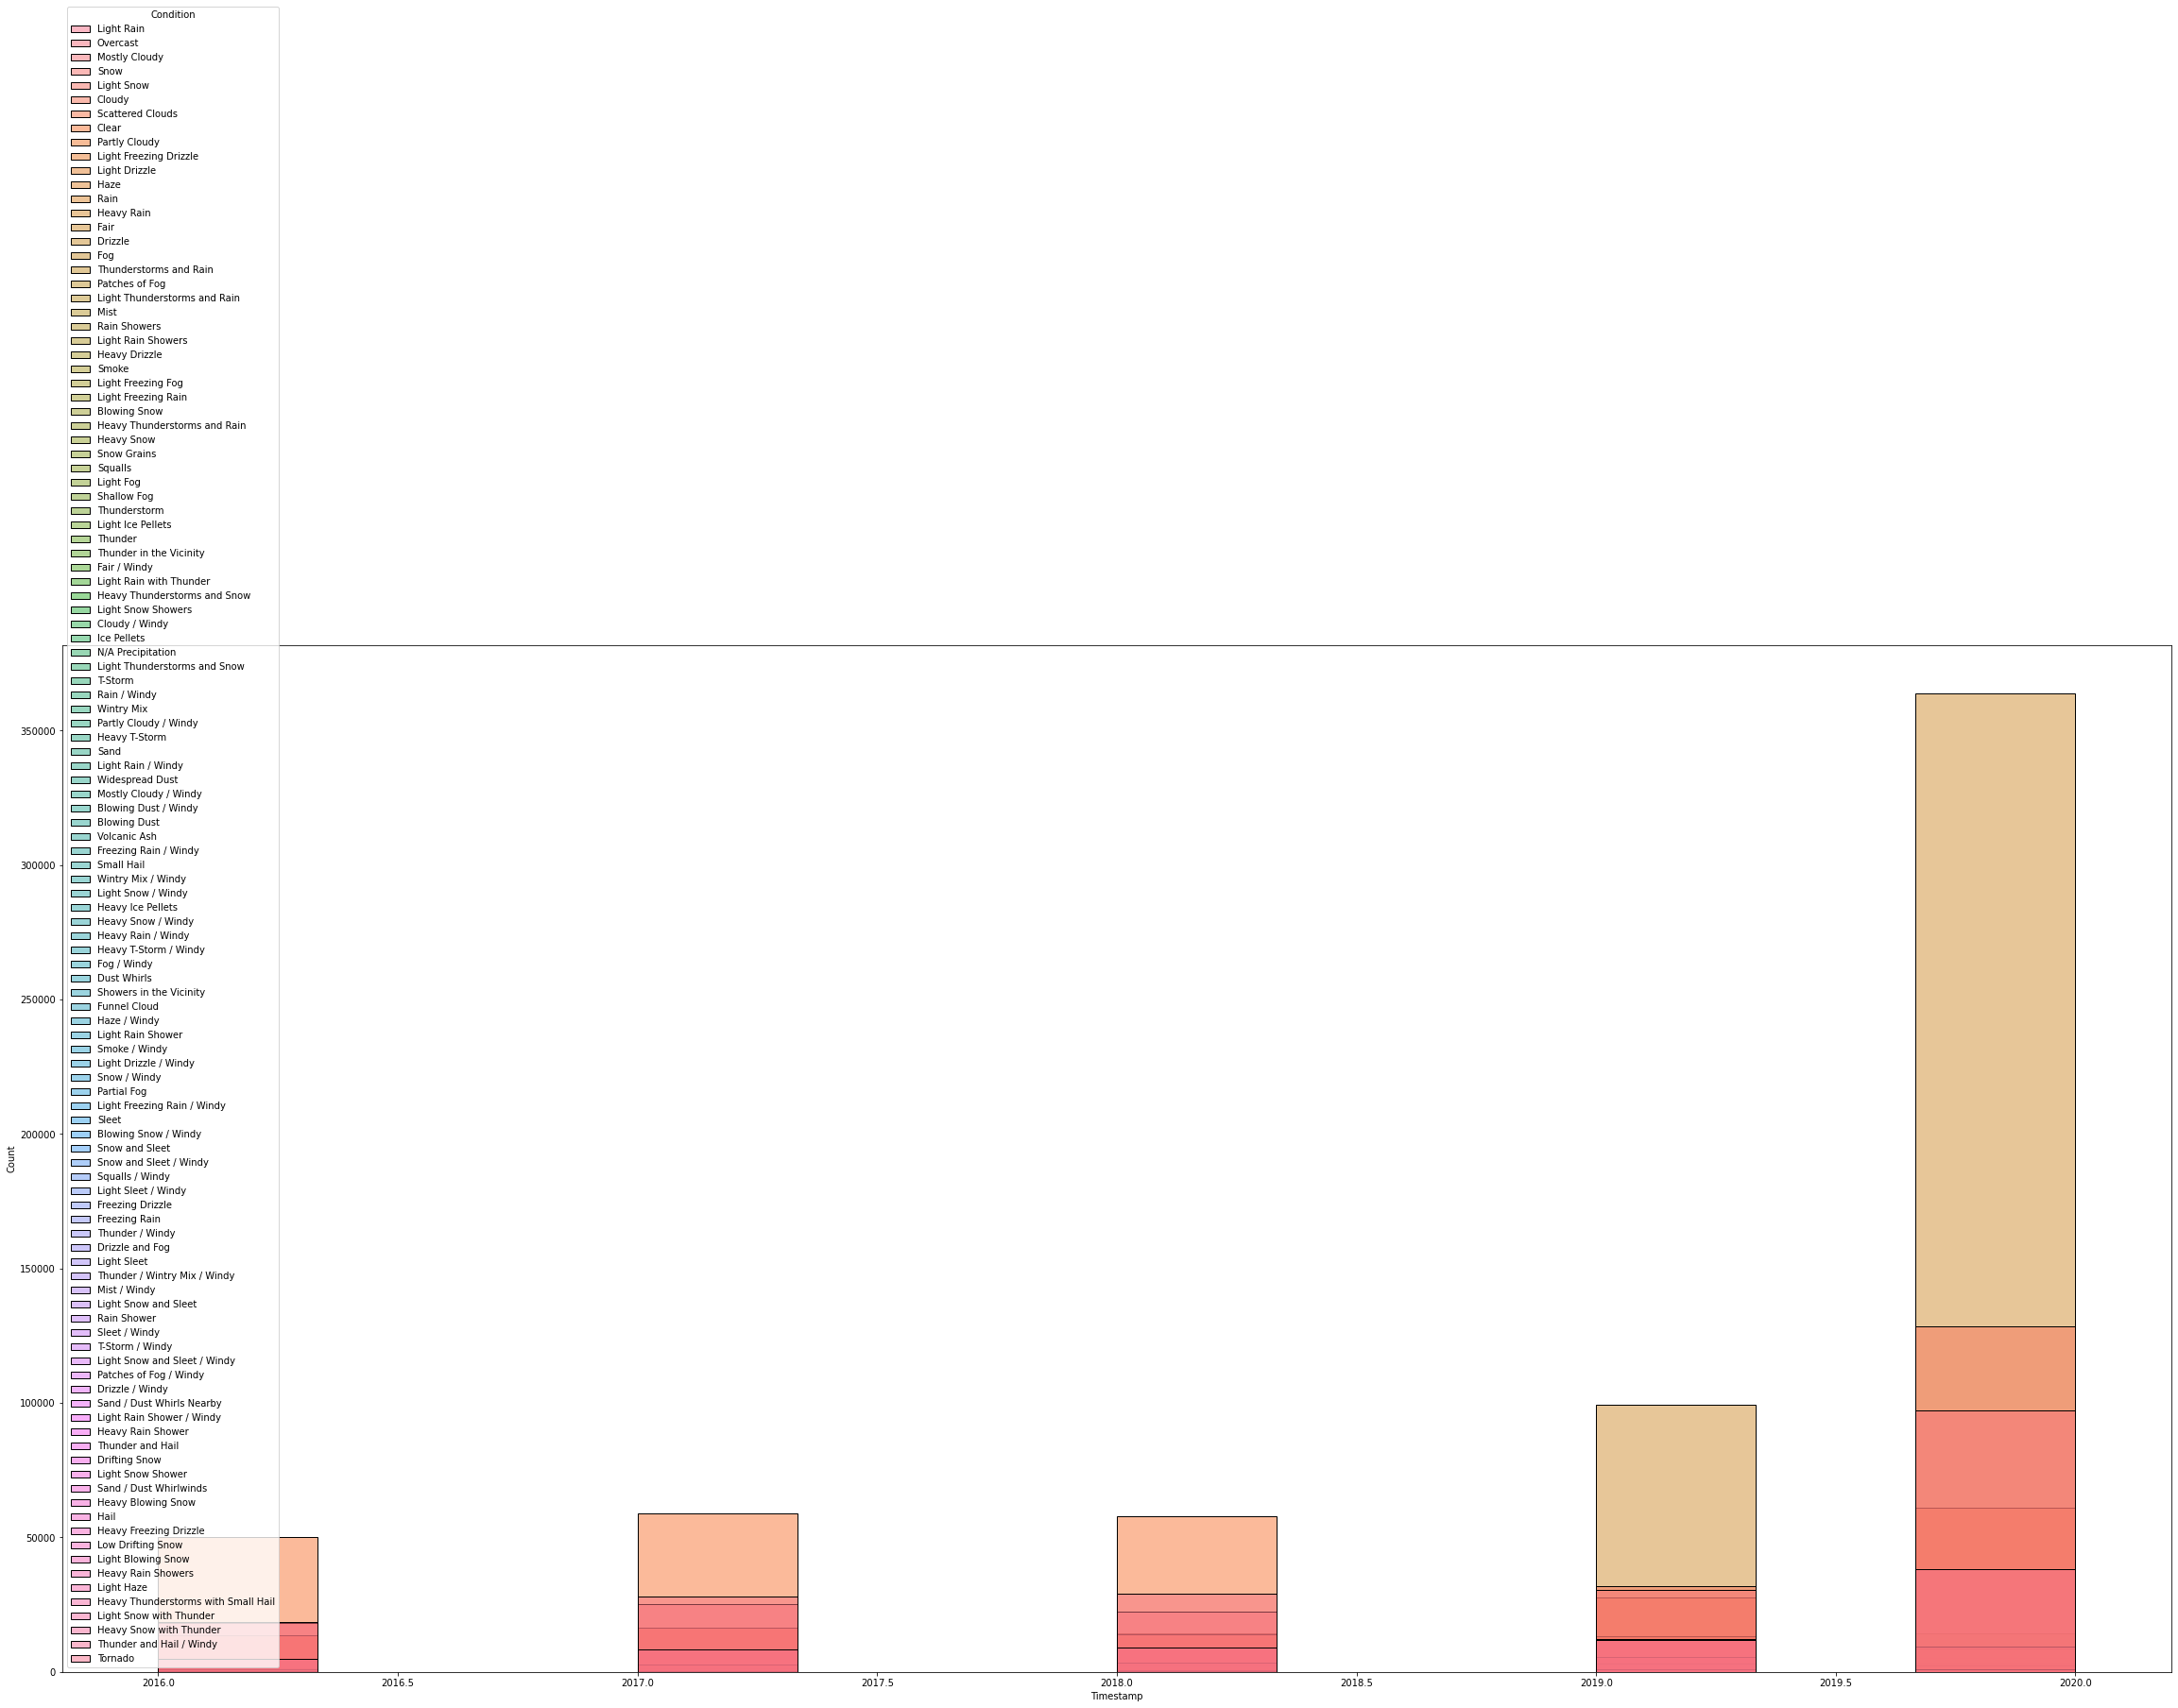

In [52]:
plt.figure(figsize=(40,20))
sns.histplot(x=data.Timestamp.dt.year,bins=12,hue=data.Condition)

Text(0.5, 0, 'hour')

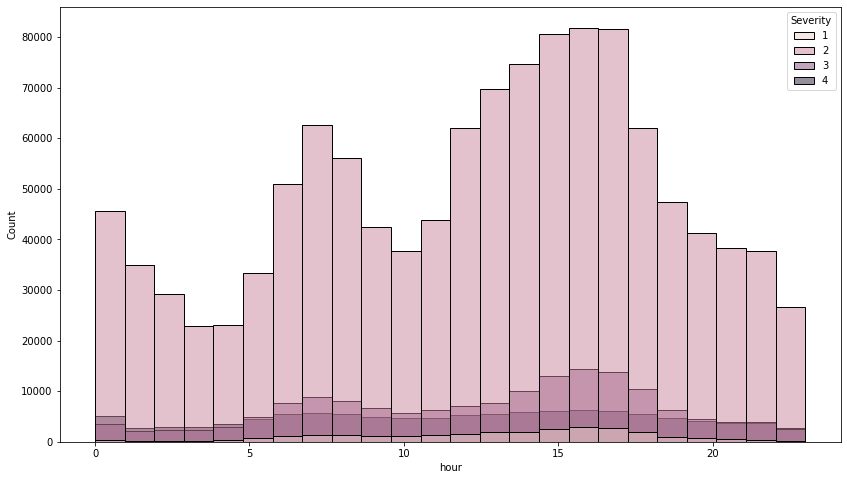

In [53]:
# accidents hist pot with respect to hour of a day 
plt.figure(figsize=(14,8))
sns.histplot(x=data.Timestamp.dt.hour,bins=24,hue=data.Severity)
plt.xlabel("hour")

Text(0.5, 0, 'week day')

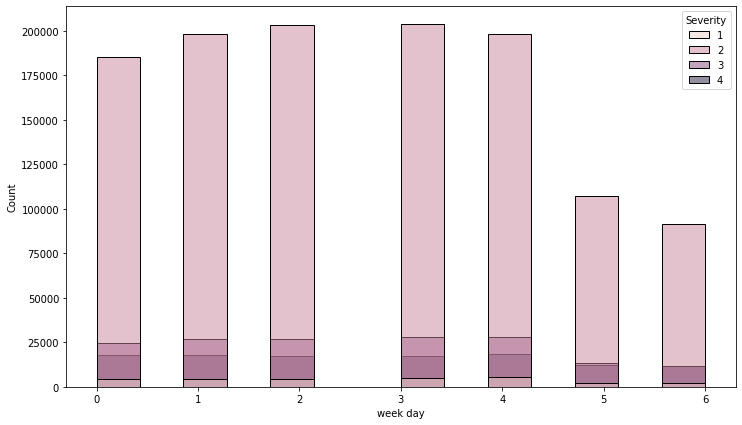

In [54]:
plt.figure(figsize=(12,7))
sns.histplot(x=data.Timestamp.dt.weekday,bins=14,hue=data.Severity)
plt.xlabel("week day")

In [55]:
data_p = data[['Id','Severity','Timestamp','Side','City','County','State','Visibility','Condition']]

In [56]:
data_p.isnull().sum()

Id                0
Severity          0
Timestamp     30264
Side              0
City             83
County            0
State             0
Visibility    44211
Condition     44007
dtype: int64

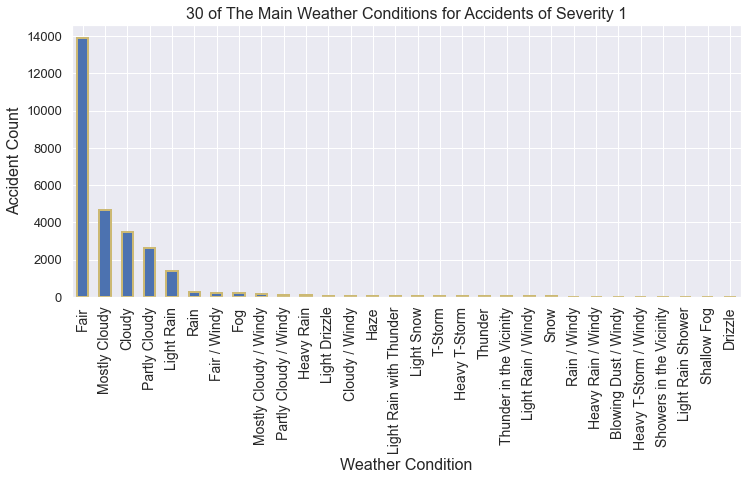

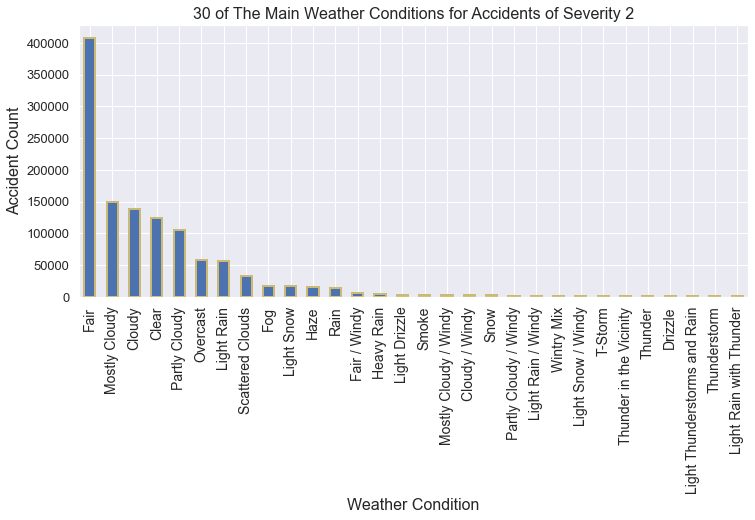

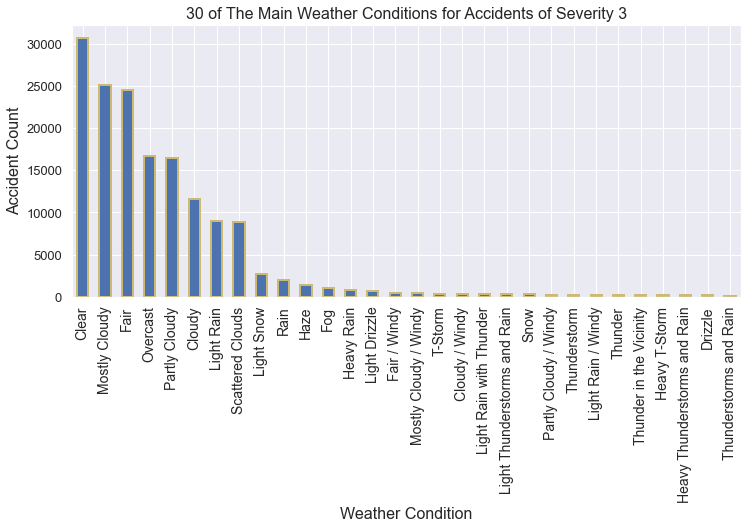

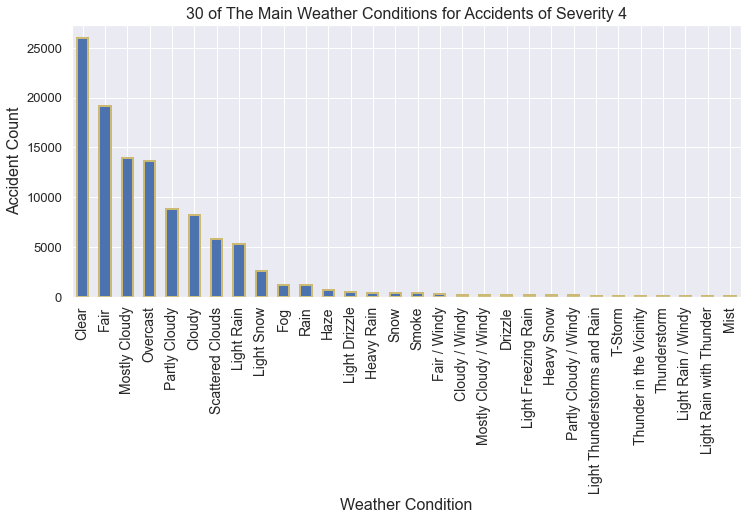

In [57]:
sns.set()
for s in np.arange(1,5):
    plt.subplots(figsize=(12,5))
    data_p.loc[data_p["Severity"] == s]['Condition'].value_counts().sort_values(ascending=False).head(30).plot.bar(width=0.5,color='b',edgecolor='y',align='center',linewidth=2)
    plt.xlabel('Weather Condition',fontsize=16)
    plt.ylabel('Accident Count',fontsize=16)
    plt.title('30 of The Main Weather Conditions for Accidents of Severity ' + str(s),fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=13)

In [58]:
data['Timestamp'] = pd.to_datetime(data['Timestamp'], infer_datetime_format=True)
data['Day_of_Week'] = data['Timestamp'].dt.day_name()


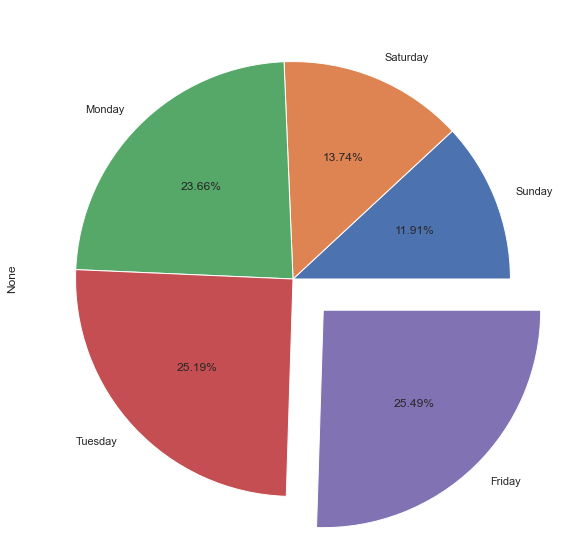

In [59]:
plt.figure(figsize=(16,10))
data.groupby('Day_of_Week') \
        .size() \
        .sort_values(ascending = True) \
        .iloc[:5] \
        .plot.pie(explode=[0,0,0,0,0.2],autopct='%1.2f%%')
plt.ioff()

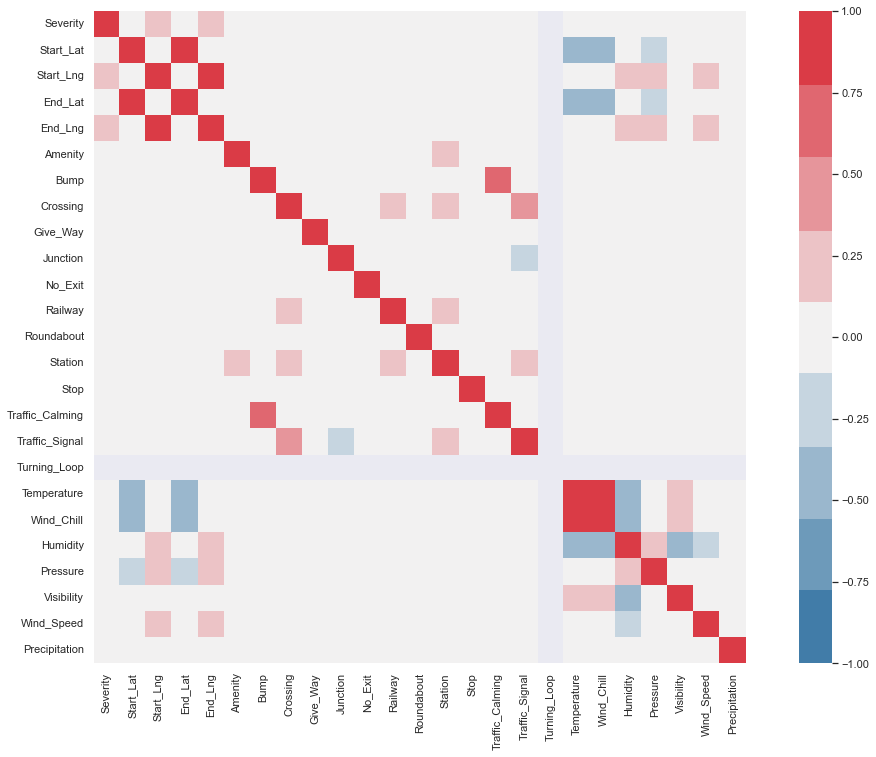

In [60]:
plt.rcParams['figure.figsize'] = (19,12)
sns.heatmap(data.corr(), vmin=-1, vmax=1, center=0,
            square=True, cmap = sns.diverging_palette(240, 10, n=9))
plt.show()

In [61]:
cor = data.corr()

#Correlation with output variable
cor_target = abs(cor["Severity"])

#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.02]
relevant_features

Severity          1.000000
Start_Lat         0.078723
Start_Lng         0.179492
End_Lat           0.078729
End_Lng           0.179495
Crossing          0.053573
Junction          0.021885
Traffic_Signal    0.042802
Wind_Chill        0.091947
Humidity          0.047240
Pressure          0.055531
Wind_Speed        0.063576
Name: Severity, dtype: float64

<AxesSubplot:ylabel='Side'>

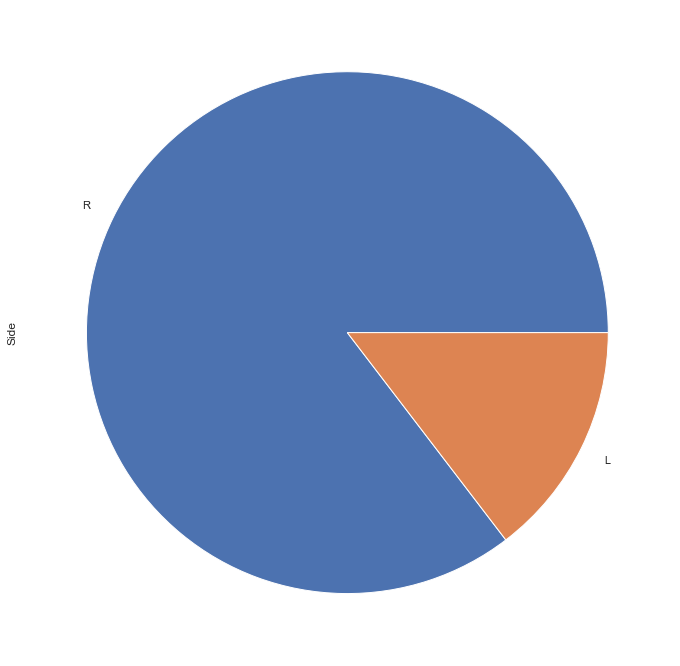

In [62]:

data['Side'].value_counts().plot.pie()


/usr/local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning:

FixedFormatter should only be used together with FixedLocator

/usr/local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning:

FixedFormatter should only be used together with FixedLocator

/usr/local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning:

FixedFormatter should only be used together with FixedLocator

/usr/local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning:

FixedFormatter should only be used together with FixedLocator



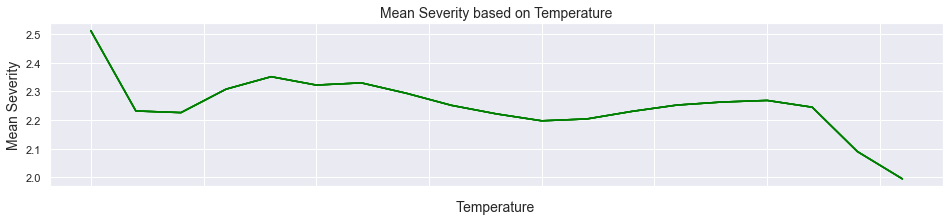

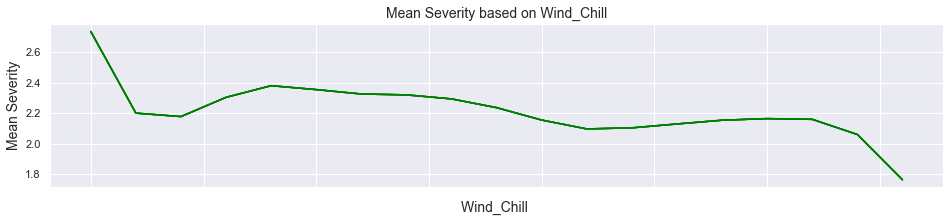

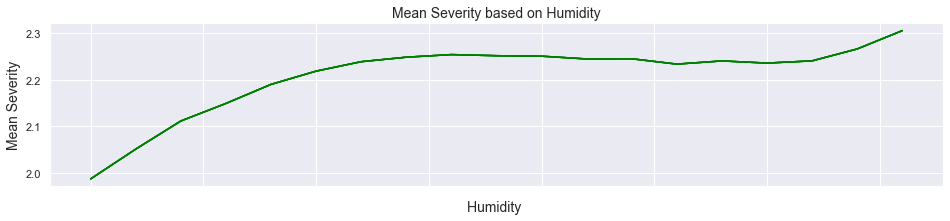

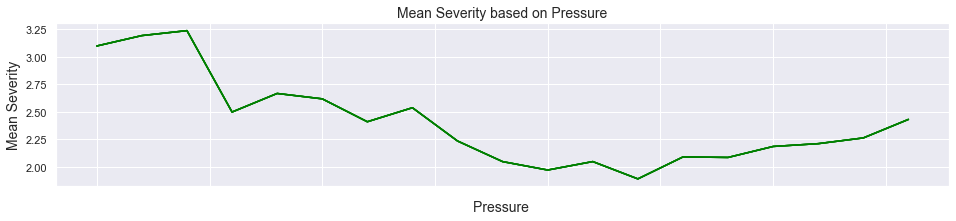

In [63]:
sns.set()
weather_factor = [ 'Temperature', 'Wind_Chill', 'Humidity', 'Pressure']

for factor in weather_factor:
   
    mini = data[factor].quantile(q=0.0001)
    maxi = data[factor].quantile(q=0.9999)
    
    plt.subplots(figsize=(16,3))
    for s in np.arange(1,5):
        data["Severity"].groupby(pd.cut(data[factor], np.linspace(mini,maxi,num=20))).mean().plot(color=['green'])
        plt.title("Mean Severity based on " + factor, fontsize=14)
        plt.xlabel(factor + " ", fontsize=14)
        plt.ylabel("Mean Severity", fontsize=14)
        plt.xticks(fontsize=11)
        plt.yticks(fontsize=11)

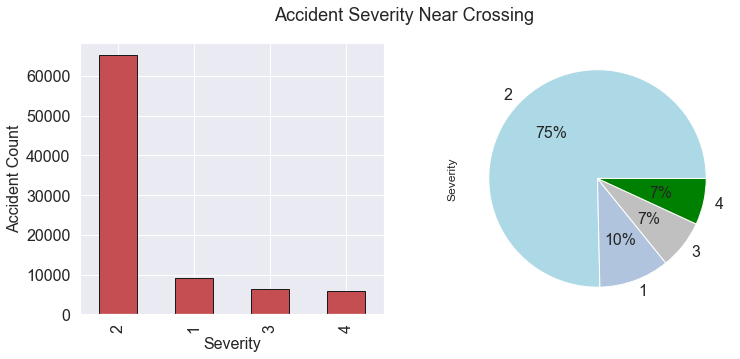

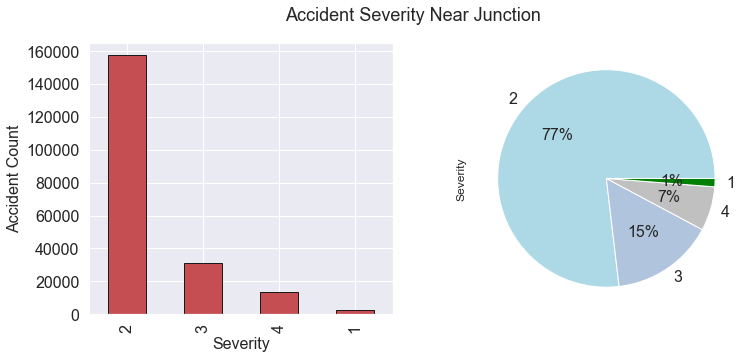

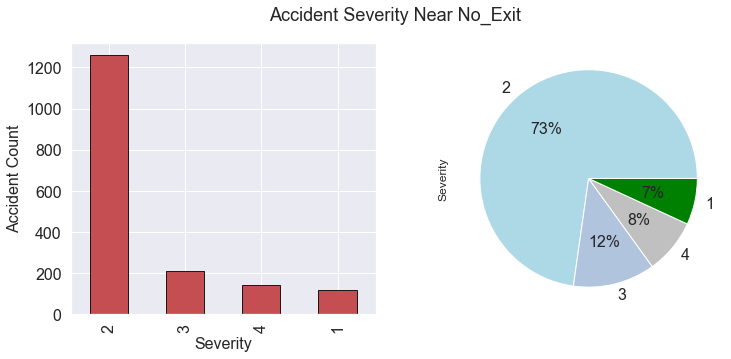

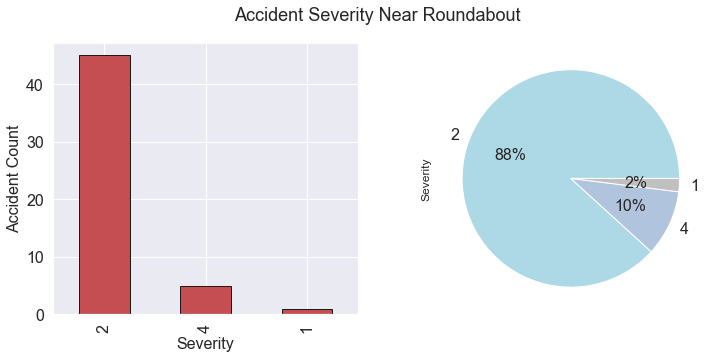

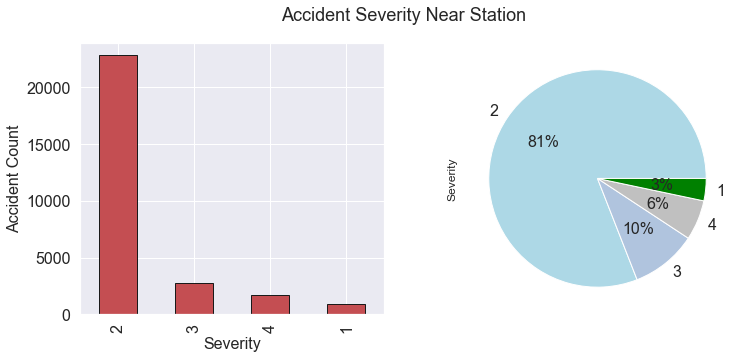

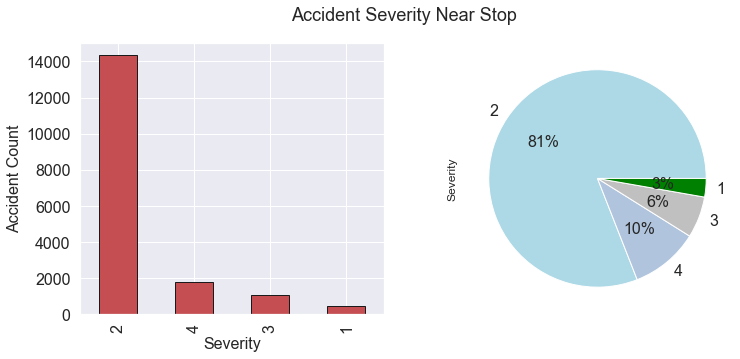

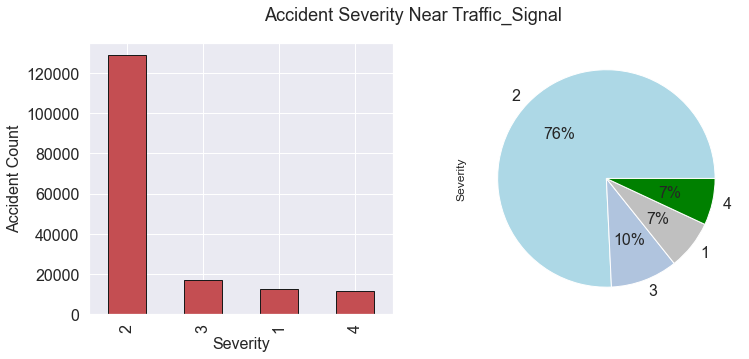

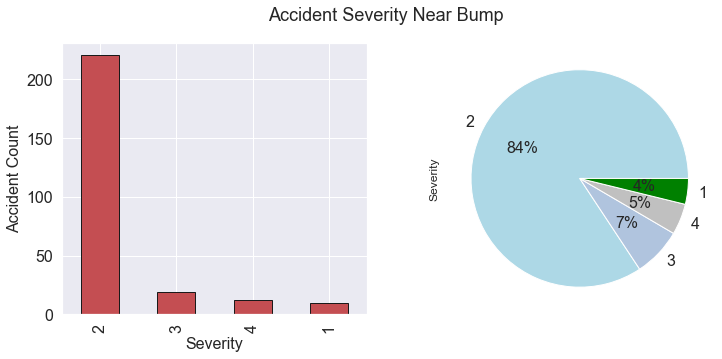

In [64]:
for area in ['Crossing','Junction', 'No_Exit','Roundabout', 'Station', 'Stop', 'Traffic_Signal', 'Turning_Loop','Bump']:
    # check if infrastructure type is found in any record 
    if (data[area] == True).sum() > 0:
        my_colors = ['lightblue','lightsteelblue','silver','green']
        plt.subplots(1,2,figsize=(12,5))
        plt.xticks(fontsize=14)
        plt.suptitle('Accident Severity Near ' + area,fontsize=18)
        plt.subplot(1,2,1)
        data.loc[data[area] == True]['Severity'].value_counts().plot.bar(width=0.5,color='r',edgecolor='k',align='center',linewidth=1)
        plt.xlabel('Severity',fontsize=16)
        plt.ylabel('Accident Count',fontsize=16)
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        plt.subplot(1,2,2)
        data.loc[data[area] == True]['Severity'].value_counts().plot.pie(autopct='%1.0f%%',fontsize=16,colors=my_colors)

In [65]:
imp_features =["Severity","Start_Lat","Start_Lng","Wind_Speed","Amenity","Crossing","Junction","Railway","Station","Stop","Traffic_Signal"]

In [66]:
df_copy1 = data.filter(imp_features, axis=1)

In [67]:
df_copy2=df_copy1.dropna()
df_copy2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1387202 entries, 0 to 1516063
Data columns (total 11 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   Severity        1387202 non-null  int64  
 1   Start_Lat       1387202 non-null  float64
 2   Start_Lng       1387202 non-null  float64
 3   Wind_Speed      1387202 non-null  float64
 4   Amenity         1387202 non-null  bool   
 5   Crossing        1387202 non-null  bool   
 6   Junction        1387202 non-null  bool   
 7   Railway         1387202 non-null  bool   
 8   Station         1387202 non-null  bool   
 9   Stop            1387202 non-null  bool   
 10  Traffic_Signal  1387202 non-null  bool   
dtypes: bool(7), float64(3), int64(1)
memory usage: 62.2 MB


In [68]:
df_copy2.describe()

Severity     Start_Lat     Start_Lng    Wind_Speed
count  1.387202e+06  1.387202e+06  1.387202e+06  1.387202e+06
mean   2.223867e+00  3.685680e+01 -9.858293e+01  7.630812e+00
std    5.954611e-01  5.209400e+00  1.846670e+01  5.637364e+00
min    1.000000e+00  2.457022e+01 -1.244976e+02  0.000000e+00
25%    2.000000e+00  3.382670e+01 -1.182125e+02  4.600000e+00
50%    2.000000e+00  3.732112e+01 -9.411944e+01  7.000000e+00
75%    2.000000e+00  4.073493e+01 -8.090933e+01  1.040000e+01
max    4.000000e+00  4.900058e+01 -6.711317e+01  9.840000e+02

## 3.0 Data Predictive Modeling

In [69]:
from sklearn.model_selection import train_test_split
y_data = df_copy2['Severity'].values
X_data = df_copy2.drop('Severity', axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.33, random_state=42)
X_train.shape

(929425, 10)

In [70]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
lr=LinearRegression()
lr.fit(X_train,y_train)
rfe = RFE(lr, n_features_to_select=1)
rfe.fit(X_train,y_train)
 
print ("Features sorted by their rank:")
print (sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), df_copy2.columns))) 

Features sorted by their rank:
[(1, 'Amenity'), (2, 'Junction'), (3, 'Wind_Speed'), (4, 'Stop'), (5, 'Crossing'), (6, 'Railway'), (7, 'Severity'), (8, 'Station'), (9, 'Start_Lat'), (10, 'Start_Lng')]


In [71]:
y_pred = lr.predict(X_test)
r2_score(y_test,y_pred)

0.04861255614169957

In [74]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.39023457192744865
Mean Squared Error: 0.3371880909785312
Root Mean Squared Error: 0.5806789913356012


In [75]:
# from sklearn import model_selection
# from sklearn.linear_model import LogisticRegression


# kfold = model_selection.KFold(n_splits=10)
# model = LogisticRegression(max_iter = 100000)
# scoring = 'accuracy'
# results = model_selection.cross_val_score(model,X_train,y_train, cv=kfold, scoring=scoring)

# print("Logistic Regression :", results.mean())

Logistic Regression : 0.8070010991223817


In [76]:
bool_features = df_copy2.select_dtypes(include=['bool'])
print('Boolean features: {}'.format(bool_features.shape))
one_hot = pd.get_dummies(bool_features)
one_hot.reset_index(drop=True, inplace=True)
one_hot.head(5)

Boolean features: (1387202, 7)


Amenity  Crossing  Junction  Railway  Station   Stop  Traffic_Signal
0    False     False     False    False    False  False           False
1    False     False     False    False    False  False           False
2    False     False     False    False    False  False            True
3    False     False     False    False    False  False           False
4    False     False     False    False    False  False           False

In [77]:
numerical_features =  df_copy2.select_dtypes(exclude=['bool'])
sc = StandardScaler()
y = df_copy2[['Severity']].values
y= sc.fit_transform(y)
numerical_features = numerical_features.drop(['Severity'], axis=1)
numerical_features = pd.DataFrame(sc.fit_transform(numerical_features), columns = numerical_features.columns)

In [78]:
X_data = np.concatenate((one_hot,numerical_features),axis=1)
df_concat = pd.concat([one_hot,numerical_features],axis=1)

In [79]:
X_train1,X_test1,y_train1,y_test1 = train_test_split(X_data, y, test_size=0.2, random_state=42)
y_t=y_train1.ravel()
y_te=y_test1.ravel()

In [80]:
# !pip install windrose
# !pip install lightgbm
import lightgbm as lgb

In [81]:
lgb_train = lgb.Dataset(X_train1, y_t)
lgb_test = lgb.Dataset(X_test1, y_te)

In [82]:
params = {
          'boosting_type': 'gbdt',
          'objective': 'regression',
          'metric': {'rmse'},
            'num_leaves': 13,
            'max_depth': -1,
          'learning_rate': 0.8,
          'feature_fraction': 0.041,
          'bagging_fraction': 0.331,
          'bagging_freq' : 5
          }

In [83]:
gbm_reg = lgb.train(params,
              lgb_train,
              num_boost_round=4000,
              valid_sets=(lgb_train, lgb_test),
            early_stopping_rounds=20,
            verbose_eval = 20)

/usr/local/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/usr/local/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024791 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 600
[LightGBM] [Info] Number of data points in the train set: 1109761, number of used features: 10
[LightGBM] [Info] Start training from score 0.000041
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

In [84]:
y_pred=gbm_reg.predict(X_test1)

In [85]:
from sklearn.metrics import mean_squared_error

score = np.sqrt(mean_squared_error(y_test1, y_pred))
print("RMSE score:", score)

RMSE score: 0.9243623209883299


In [86]:
# !pip install xgboost
# !pip install --upgrade xgboost

In [87]:
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [88]:
df_copy2['Severity1']=np.where(df_copy2['Severity']==4 ,'high','low')

<ipython-input-88-728c804d7098>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [89]:
df_copy2['Severity1'].value_counts()

low     1289475
high      97727
Name: Severity1, dtype: int64

In [90]:
from sklearn.model_selection import train_test_split
y_data = df_copy2['Severity1'].values
X_data = df_copy2.drop(['Severity','Severity1'], axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.20, random_state=42)
X_train.shape

(1109761, 10)

In [91]:
np.unique(y_train)

array(['high', 'low'], dtype=object)

In [92]:
# fit model
model = XGBClassifier()
model.fit(X_train, y_train)

/usr/local/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[17:18:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [93]:
print(model)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)


In [94]:
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [value for value in y_pred]

In [95]:
np.unique(predictions)

array(['high', 'low'], dtype='<U4')

In [96]:
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 93.49%


## 4.0 Inference

A short summary of our analysis:
1. There is a high probability of an accident occurring during peak hours when people are traveling to work and going back home.
2. There is a high probability of an accident occurring during the holiday season because of increased traffic, increased drunk driving,etc.
3. The number of accidents is higher in big cities because of higher population which leads to an increased amount of traffic.
4. The temperature of a location seem to have a relation with the number of accidents. Number of accidents is low in warmer or colder areas because of lower population.

Besides the above insights, we used ML Classification Techniques to predict severity of an accident, given location details and weather conditions.